## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

![A diagram of a generator and discriminator](https://www.tensorflow.org/tutorials/generative/images/gan1.png)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](https://www.tensorflow.org/tutorials/generative/images/gan2.png)

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

To learn more about GANs, we recommend MIT's [Intro to Deep Learning](http://introtodeeplearning.com/) course.

In [1]:
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
# Generator

generator = tf.keras.models.Sequential()

generator.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Reshape((7, 7, 256)))
assert generator.output_shape == (None, 7, 7, 256)

generator.add(layers.Conv2DTranspose(filters=128, kernel_size=(5, 5), padding='same', use_bias=False))
assert generator.output_shape == (None, 7, 7, 128)
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
assert generator.output_shape == (None, 14, 14, 64)
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(filters=1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
assert generator.output_shape == (None, 28, 28, 1)

In [8]:
# Discriminator

discriminator = tf.keras.models.Sequential()

discriminator.add(layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1))

In [9]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [10]:
def discriminator_loss(real, fake):
    real_loss = loss(tf.ones_like(real), real)
    fake_loss = loss(tf.zeros_like(fake), fake)
    return real_loss + fake_loss

In [11]:
def generator_loss(fake):
    return loss(tf.ones_like(fake), fake)

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [13]:
checkpoints_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoints_dir, 'ckpt')

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, 
                                 discriminator_optimizer=discriminator_optimizer, 
                                 generator=generator, 
                                 discriminator=discriminator)

In [14]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

In [15]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [16]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = generator(noise, training=True)
        
        real = discriminator(images, training=True)
        fake = discriminator(generated, training=True)
        
        gen_loss = generator_loss(fake)
        disc_loss = discriminator_loss(real, fake)
        
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
        

In [17]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

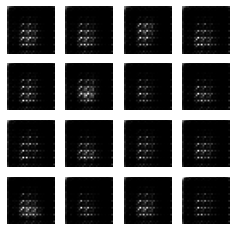

. 

KeyboardInterrupt: 

In [18]:
for epoch in range(epochs):
    for batch in train_dataset:
        train_step(batch)
        
    print('.', end=' ')
    
    if epoch % 15 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
display.clear_output(wait=True)
generate_and_save_images(generator, epochs, seed)

In [ ]:
checkpoint.save(file_prefix=checkpoint_prefix)

### Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(epochs)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)